# Task 1.1: Unstructured Pruning

### 1. Initial Setup with Baseline Accuracy

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from tqdm import tqdm  # For progress tracking

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-100 dataset with updated transformations (Resize to 224x224 for VGG input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Load the VGG-11 model and modify the classifier for CIFAR-100 (100 classes)
model = models.vgg11(pretrained=True)
model.classifier[6] = nn.Linear(4096, 100)  # Update final classifier layer
model = model.to(device)

# Freeze backbone layers and all classifier layers except the last one
for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier[:-1]:  # Freeze all classifier layers except the last one
    param.requires_grad = False

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001, weight_decay=1e-4)

# Training loop for fine-tuning
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    # Add tqdm for the training loop
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))

    # Calculate validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f'Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.4f}')

# Save baseline accuracy
baseline_accuracy = val_accuracy
print(f'Baseline Validation Accuracy: {baseline_accuracy:.4f}')


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/3: 100%|██████████| 782/782 [03:24<00:00,  3.83batch/s, loss=1.94]


Validation Accuracy after Epoch 1: 0.5732


Epoch 2/3: 100%|██████████| 782/782 [03:22<00:00,  3.85batch/s, loss=1.62]


Validation Accuracy after Epoch 2: 0.6043


Epoch 3/3: 100%|██████████| 782/782 [03:22<00:00,  3.85batch/s, loss=1.57]


Validation Accuracy after Epoch 3: 0.6080
Baseline Validation Accuracy: 0.6080


In [48]:
# Import the necessary library for Google Colab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save model weights to Google Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/vgg11_baseline.pth')
print("Baseline model weights saved to Google Drive as 'vgg11_baseline.pth'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Baseline model weights saved to Google Drive as 'vgg11_baseline.pth'


### 2. Plotting Initial Weight Distribution (Pre-Pruning)

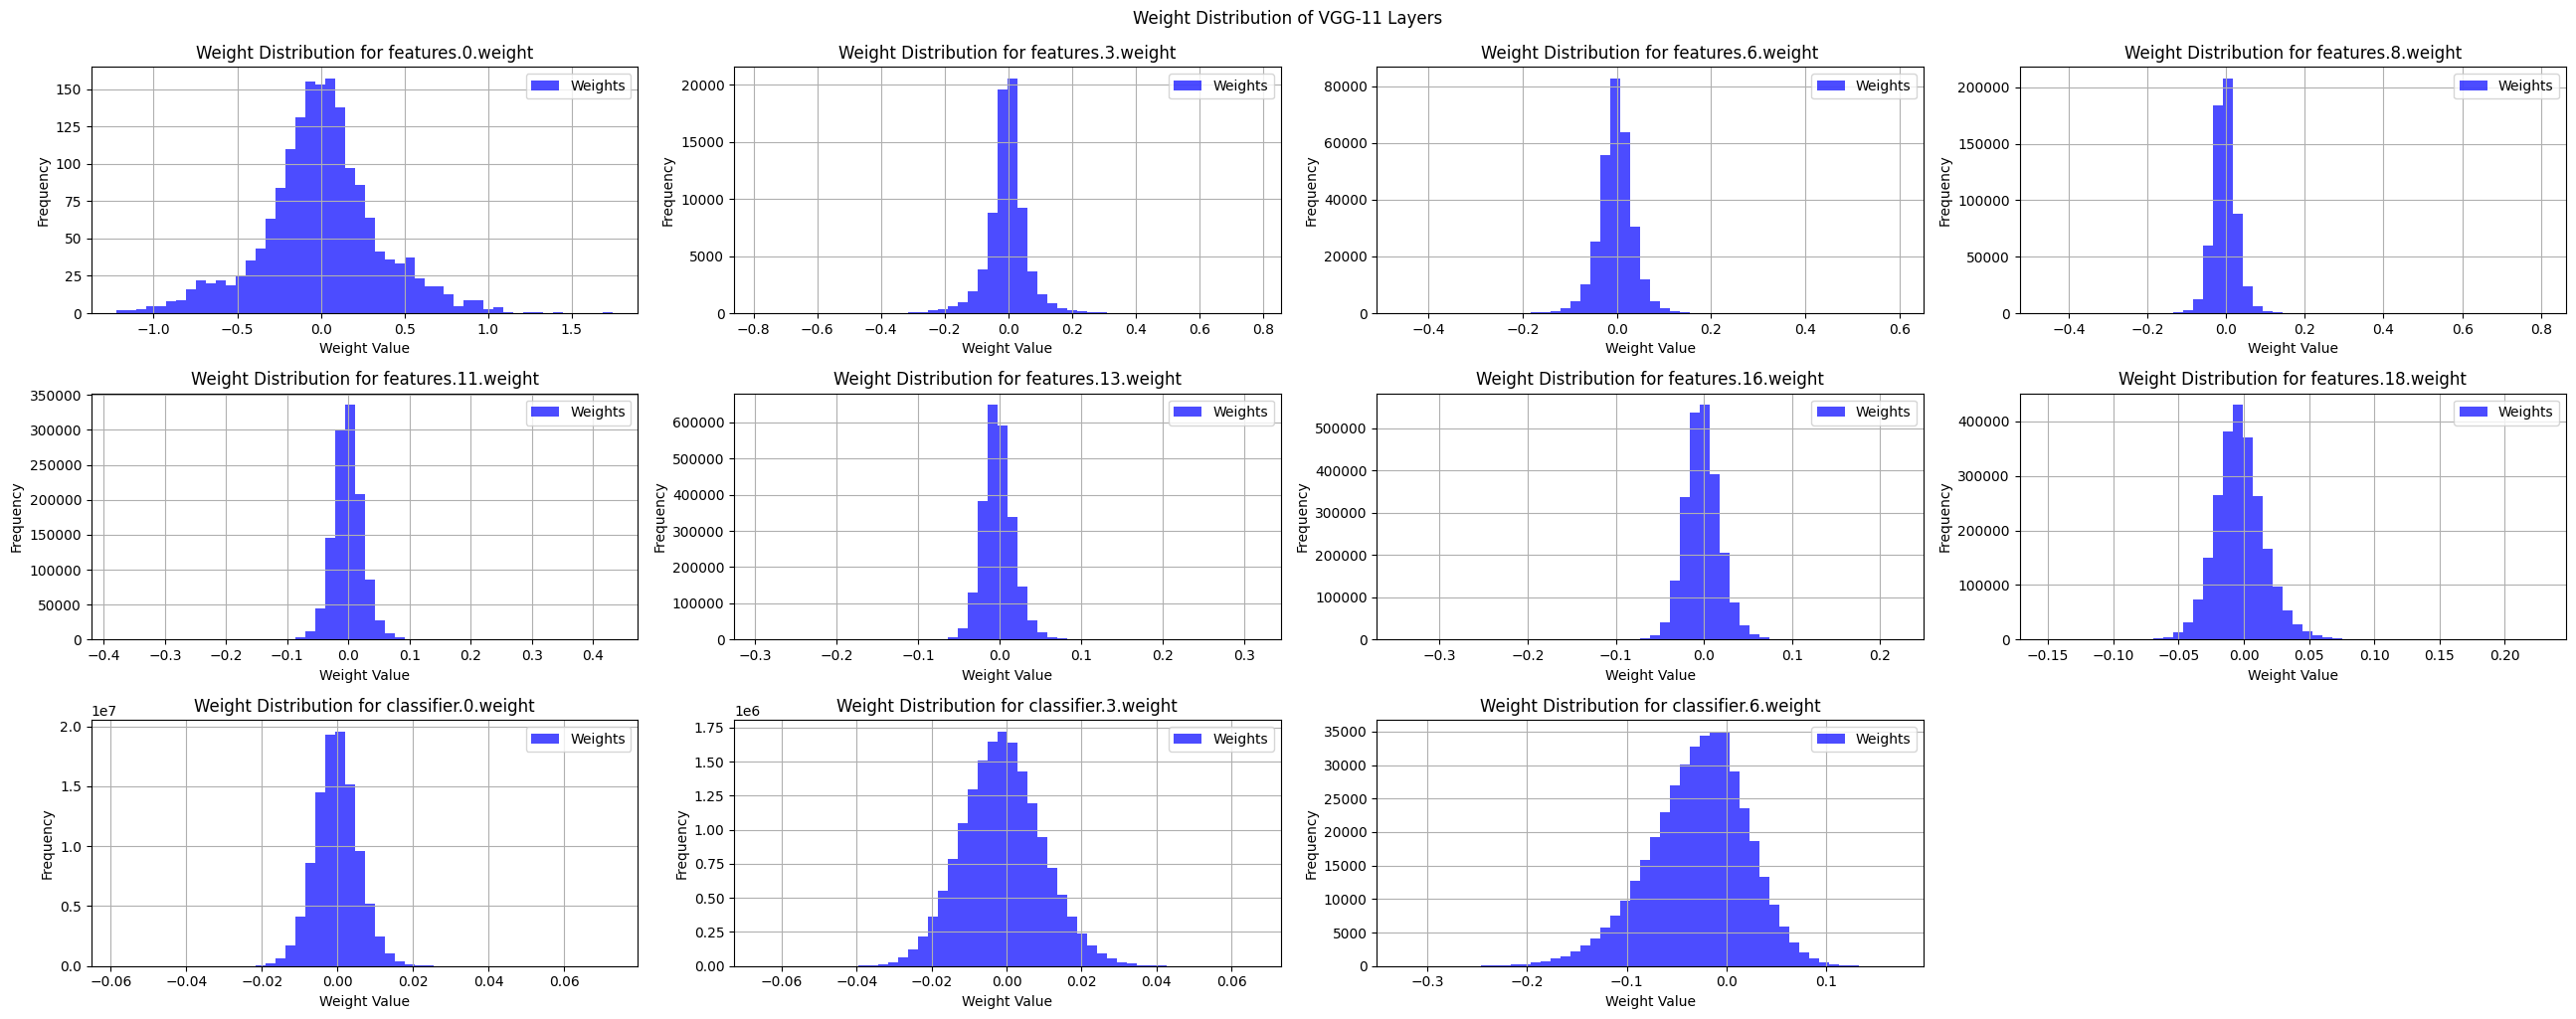

Initial weight distribution plots displayed and data stored.


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot histograms of weight distributions for each layer
def plot_weight_histograms(model):
    weight_histograms = {}
    weights_to_plot = [name for name, param in model.named_parameters() if 'weight' in name]
    num_layers = len(weights_to_plot)

    # Specify the grid layout for subplots (e.g., 4 columns)
    n_cols = 4
    n_rows = (num_layers + n_cols - 1) // n_cols  # Calculate number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(26, 10))
    axes = axes.flatten()  # Flatten to easily iterate through axes

    for i, name in enumerate(weights_to_plot):
        param = dict(model.named_parameters())[name]
        weights = param.data.cpu().numpy().flatten()

        # Store histogram data for later comparisons
        weight_histograms[name] = weights

        # Plot histogram with focus on the specified zoom range
        axes[i].hist(weights, bins=50, color='blue', alpha=0.7, label='Weights')
        axes[i].set_title(f'Weight Distribution for {name}')
        axes[i].set_xlabel('Weight Value')
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True)

    # Hide any remaining unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle("Weight Distribution of VGG-11 Layers", y=1.02)
    plt.show()

    return weight_histograms

# Generate and store initial weight histograms (pre-pruning)
initial_weight_histograms = plot_weight_histograms(model)
print("Initial weight distribution plots displayed and data stored.")


### 3. Implementing L2-Norm Magnitude-Based Pruning & Plotting Post pruning Weight Distribution


Sparsity levels after pruning:
Layer: features.0, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: features.3, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: features.6, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: features.8, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: features.11, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: features.13, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: features.16, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: features.18, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: classifier.0, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: classifier.3, Target Sparsity: 0.50, Actual Sparsity: 0.50
Layer: classifier.6, Target Sparsity: 0.50, Actual Sparsity: 0.50


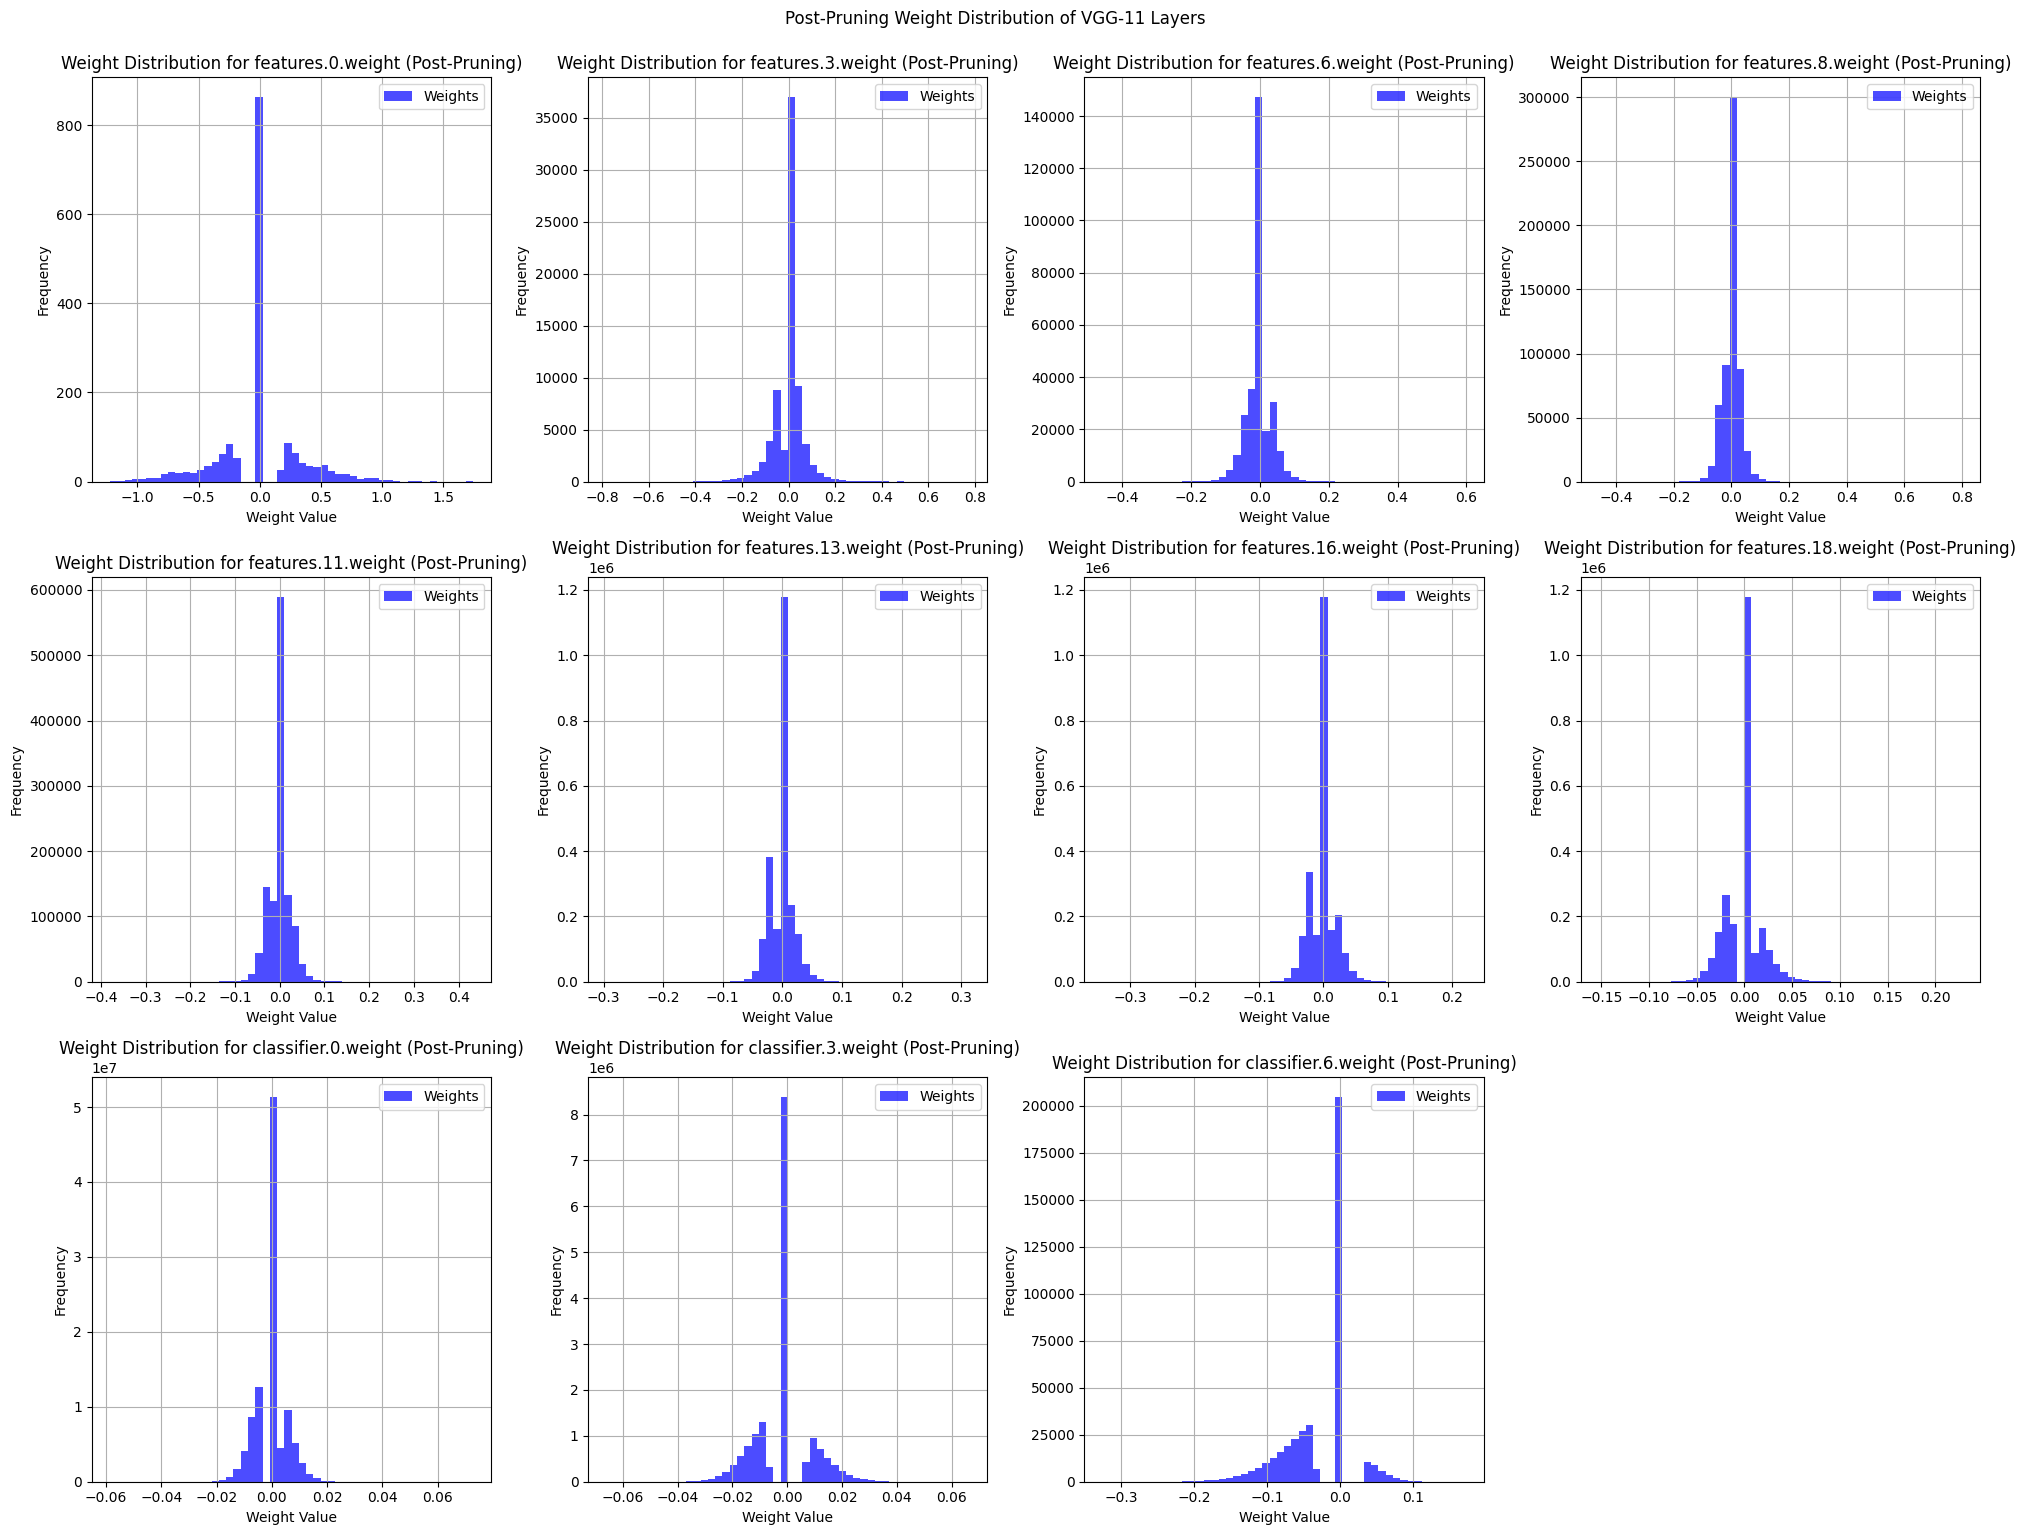

Post-pruning weight distribution plots displayed.


In [50]:
import torch.nn.utils.prune as prune

# Ensure all layers are unfrozen for pruning
for param in model.parameters():
    param.requires_grad = True

# Set a high target sparsity ratio for effective pruning visualization
target_sparsity_ratio = 0.5  # 50% sparsity for clear impact

# Function to apply and then remove pruning reparameterization
def prune_and_remove(layer, sparsity_ratio):
    prune.l1_unstructured(layer, name='weight', amount=sparsity_ratio)
    prune.remove(layer, 'weight')  # Permanently zero out pruned weights

# Apply pruning to each convolutional and fully connected layer
for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        prune_and_remove(layer, target_sparsity_ratio)

# Function to calculate and print sparsity for each layer
def calculate_sparsity(layer):
    total_weights = layer.weight.nelement()  # Total number of weights
    zero_weights = torch.sum(layer.weight == 0).item()  # Number of zero weights
    sparsity = zero_weights / total_weights  # Sparsity ratio
    return sparsity

# Print sparsity levels for each layer
print("\nSparsity levels after pruning:")
for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear)) and hasattr(layer, 'weight'):
        actual_sparsity = calculate_sparsity(layer)
        print(f"Layer: {name}, Target Sparsity: {target_sparsity_ratio:.2f}, Actual Sparsity: {actual_sparsity:.2f}")

# Function to plot weight distributions after pruning
def plot_post_pruning_weight_histograms(model):
    post_pruning_weight_histograms = {}
    weights_to_plot = [name for name, param in model.named_parameters() if 'weight' in name]
    num_layers = len(weights_to_plot)

    # Specify grid layout (e.g., 4 columns for consistency with pre-pruning plot)
    n_cols = 4
    n_rows = (num_layers + n_cols - 1) // n_cols  # Calculate number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
    axes = axes.flatten()  # Flatten to easily iterate through axes

    for i, name in enumerate(weights_to_plot):
        param = dict(model.named_parameters())[name]
        weights = param.data.cpu().numpy().flatten()

        # Store histogram data for later comparisons
        post_pruning_weight_histograms[name] = weights

        # Plot histogram for the full range of weights
        axes[i].hist(weights, bins=50, color='blue', alpha=0.7, label='Weights')
        axes[i].set_title(f'Weight Distribution for {name} (Post-Pruning)')
        axes[i].set_xlabel('Weight Value')
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True)

    # Hide any remaining unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle("Post-Pruning Weight Distribution of VGG-11 Layers", y=1.02)
    plt.show()

    return post_pruning_weight_histograms

# Generate and display post-pruning weight distribution plots
post_pruning_weight_histograms = plot_post_pruning_weight_histograms(model)
print("Post-pruning weight distribution plots displayed.")


### 4. Sensitivity Analysis

Analyzing sensitivity for layer: features.0


Pruning features.0: 100%|██████████| 6/6 [04:05<00:00, 41.00s/it]


Analyzing sensitivity for layer: features.3


Pruning features.3: 100%|██████████| 6/6 [04:06<00:00, 41.08s/it]


Analyzing sensitivity for layer: features.6


Pruning features.6: 100%|██████████| 6/6 [04:06<00:00, 41.02s/it]


Analyzing sensitivity for layer: features.8


Pruning features.8: 100%|██████████| 6/6 [04:06<00:00, 41.13s/it]


Analyzing sensitivity for layer: features.11


Pruning features.11: 100%|██████████| 6/6 [04:06<00:00, 41.15s/it]


Analyzing sensitivity for layer: features.13


Pruning features.13: 100%|██████████| 6/6 [04:06<00:00, 41.00s/it]


Analyzing sensitivity for layer: features.16


Pruning features.16: 100%|██████████| 6/6 [04:06<00:00, 41.11s/it]


Analyzing sensitivity for layer: features.18


Pruning features.18: 100%|██████████| 6/6 [04:06<00:00, 41.06s/it]


Analyzing sensitivity for layer: classifier.0


Pruning classifier.0: 100%|██████████| 6/6 [04:13<00:00, 42.29s/it]


Analyzing sensitivity for layer: classifier.3


Pruning classifier.3: 100%|██████████| 6/6 [04:07<00:00, 41.32s/it]


Analyzing sensitivity for layer: classifier.6


Pruning classifier.6: 100%|██████████| 6/6 [04:06<00:00, 41.10s/it]


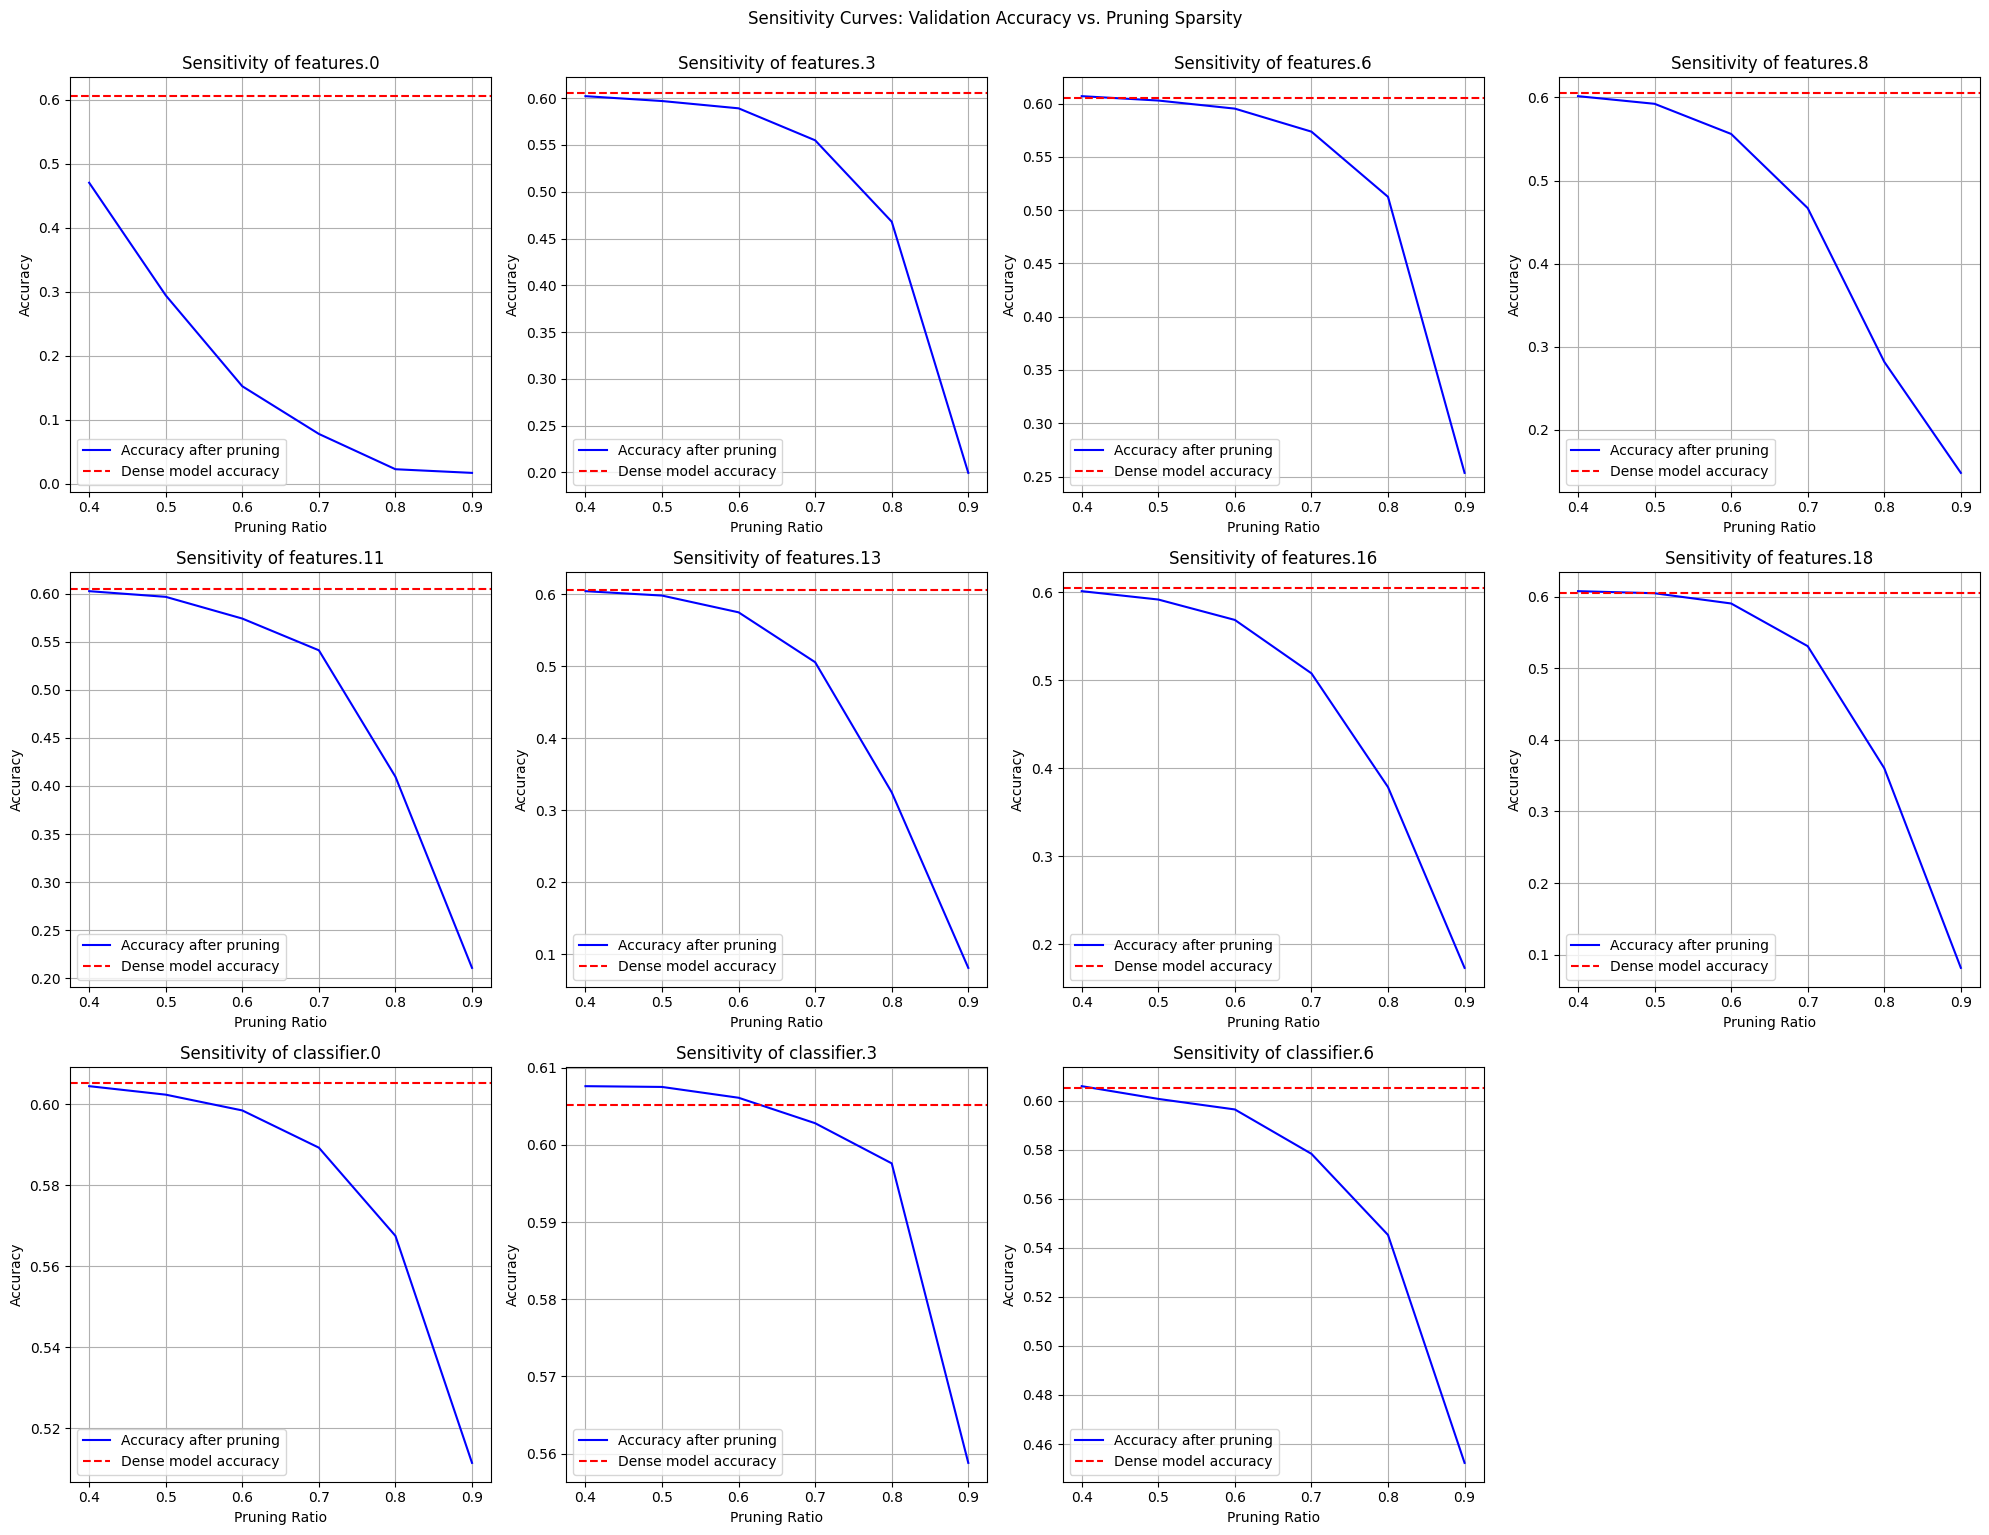

In [29]:
# Use the baseline_accuracy obtained from the fine-tuning step
baseline_accuracy = val_accuracy  # Replace this with the actual baseline accuracy variable if different

# Save a copy of the model’s initial state for accurate restoration
initial_model_state = model.state_dict()

# Sensitivity Analysis Function
def sensitivity_analysis(model, val_loader, sparsity_levels=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    sensitivity_results = {}
    criterion = nn.CrossEntropyLoss()

    # Iterate over each layer for sensitivity analysis
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            layer_results = []
            print(f"Analyzing sensitivity for layer: {name}")

            # Loop over different sparsity levels
            for sparsity in tqdm(sparsity_levels, desc=f"Pruning {name}"):
                # Apply temporary pruning
                prune.l1_unstructured(layer, name='weight', amount=sparsity)

                # Evaluate the model after pruning this layer
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                accuracy = correct / total
                layer_results.append((sparsity, accuracy))

                # Remove pruning to restore the original weights
                prune.remove(layer, 'weight')

            # Restore model to its initial state after testing each layer
            model.load_state_dict(initial_model_state)
            sensitivity_results[name] = layer_results

    return sensitivity_results

# Run sensitivity analysis
sensitivity_results = sensitivity_analysis(model, val_loader)

# Plotting function for sensitivity analysis results with baseline accuracy reference
def plot_sensitivity_analysis(sensitivity_results, baseline_accuracy):
    n_layers = len(sensitivity_results)
    n_cols = 4  # Adjust columns to fit
    n_rows = (n_layers + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
    axes = axes.flatten()

    for i, (layer_name, results) in enumerate(sensitivity_results.items()):
        sparsity_levels, accuracies = zip(*results)

        # Plot the accuracy after pruning for each sparsity level
        axes[i].plot(sparsity_levels, accuracies, label="Accuracy after pruning", color="blue")
        # Add a red dashed line for the baseline accuracy
        axes[i].axhline(y=baseline_accuracy, color="red", linestyle="--", label="Dense model accuracy")
        axes[i].set_title(f"Sensitivity of {layer_name}")
        axes[i].set_xlabel("Pruning Ratio")
        axes[i].set_ylabel("Accuracy")
        axes[i].legend()
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle("Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity", y=1.02)
    plt.show()

# Plot sensitivity analysis results with baseline accuracy reference
plot_sensitivity_analysis(sensitivity_results, baseline_accuracy)


### 5. Setting Final Sparsity Ratios for 25% Overall Sparsity:

In [45]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import torch.nn.utils.prune as prune

# Mount Google Drive to save files
drive.mount('/content/drive')

# Target overall sparsity
target_overall_sparsity = 0.25

# Calculate total number of weights in the model
total_weights = sum(layer.weight.nelement() for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.Linear)))

# Function to assign sparsity ratios based on sensitivity and target sparsity
def assign_sparsity_ratios(sensitivity_results, total_weights, target_overall_sparsity):
    layer_sparsities = {}
    total_pruned_weights = 0

    # Iterate over each layer and assign sparsity based on sensitivity
    for name, sensitivity in sensitivity_results.items():
        layer_sparsity = 0.5  # Base value, adjust based on sensitivity if needed
        if min([acc for _, acc in sensitivity]) > 0.8 * baseline_accuracy:
            layer_sparsity = 0.3  # Less aggressive for very sensitive layers
        elif min([acc for _, acc in sensitivity]) < 0.6 * baseline_accuracy:
            layer_sparsity = 0.7  # More aggressive for less sensitive layers

        layer_sparsities[name] = layer_sparsity

        # Estimate number of pruned weights for this layer
        layer_weight_count = sum(param.nelement() for param_name, param in model.named_parameters() if name in param_name)
        pruned_weights = int(layer_sparsity * layer_weight_count)
        total_pruned_weights += pruned_weights

    # Adjust sparsity ratios if needed to meet the target overall sparsity
    current_overall_sparsity = total_pruned_weights / total_weights
    adjustment_factor = target_overall_sparsity / current_overall_sparsity
    for layer in layer_sparsities:
        layer_sparsities[layer] = min(1.0, layer_sparsities[layer] * adjustment_factor)

    return layer_sparsities

# Assign final sparsity ratios
final_sparsity_ratios = assign_sparsity_ratios(sensitivity_results, total_weights, target_overall_sparsity)

# Apply final sparsity to each layer
for name, layer in model.named_modules():
    if name in final_sparsity_ratios and isinstance(layer, (nn.Conv2d, nn.Linear)):
        prune.l1_unstructured(layer, name='weight', amount=final_sparsity_ratios[name])
        prune.remove(layer, 'weight')  # Remove mask to make pruning permanent

# Calculate actual sparsity per layer after applying final pruning
def calculate_actual_sparsity():
    actual_sparsity_per_layer = {}
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)) and hasattr(layer, 'weight'):
            total = layer.weight.nelement()
            zero_count = torch.sum(layer.weight == 0).item()
            actual_sparsity_per_layer[name] = zero_count / total
    return actual_sparsity_per_layer

# Get actual sparsity results
actual_sparsity_per_layer = calculate_actual_sparsity()

# Calculate overall sparsity of the model
def calculate_overall_sparsity():
    total_weights = sum(layer.weight.nelement() for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.Linear)))
    zero_weights = sum((layer.weight == 0).sum().item() for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.Linear)))
    return zero_weights / total_weights

overall_sparsity = calculate_overall_sparsity()

# Create a DataFrame for Assigned and Actual Sparsity Ratios
def create_sparsity_table(final_sparsity_ratios, actual_sparsity_per_layer, overall_sparsity):
    data = {
        "Layer": list(final_sparsity_ratios.keys()),
        "Assigned Sparsity": list(final_sparsity_ratios.values()),
        "Actual Sparsity": [actual_sparsity_per_layer[layer] for layer in final_sparsity_ratios]
    }
    df = pd.DataFrame(data)
    df = df.round(2)  # Round values for cleaner display
    overall_row = pd.DataFrame({"Layer": ["Overall"], "Assigned Sparsity": [target_overall_sparsity], "Actual Sparsity": [overall_sparsity]})
    df = pd.concat([df, overall_row], ignore_index=True)
    return df

# Generate and display the table in Jupyter Notebook
sparsity_df = create_sparsity_table(final_sparsity_ratios, actual_sparsity_per_layer, overall_sparsity)
display(sparsity_df)  # Display in notebook

# Apply style and save to HTML file
styled_df = sparsity_df.style.set_properties(**{
    'background-color': 'black',
    'color': 'white',
    'border-color': 'white'
}).set_table_styles([{
    'selector': 'thead th',
    'props': [('background-color', 'darkgreen'), ('color', 'white')]
}]).set_caption("Assigned vs. Actual Sparsity Ratios per Layer")

# Save the styled DataFrame as an HTML file
sparsity_table_path = "/content/drive/MyDrive/sparsity_results.html"
with open(sparsity_table_path, 'w') as file:
    file.write(styled_df.to_html())
print(f"Sparsity table saved to {sparsity_table_path}")

# Save the pruned model
pruned_model_path = "/content/drive/MyDrive/pruned_vgg11_model.pth"
torch.save(model.state_dict(), pruned_model_path)
print(f"Pruned model saved to {pruned_model_path}")

# Save per-layer sparsity information
sparsity_info_path = "/content/drive/MyDrive/sparsity_info.pth"
torch.save(actual_sparsity_per_layer, sparsity_info_path)
print(f"Sparsity information saved to {sparsity_info_path}")

# Optional: Display the saved sparsity info for verification
print("Per-layer sparsity information:")
for layer, sparsity in actual_sparsity_per_layer.items():
    print(f"Layer: {layer}, Sparsity: {sparsity:.2f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Layer,Assigned Sparsity,Actual Sparsity
0,features.0,0.53,0.530000
1,features.3,0.53,0.530000
2,features.6,0.53,0.530000
3,features.8,0.53,0.530000
4,features.11,0.53,0.530000
5,features.13,0.53,0.530000
6,features.16,0.53,0.530000
7,features.18,0.53,0.530000
8,classifier.0,0.23,0.230000
9,classifier.3,0.23,0.230000


Sparsity table saved to /content/drive/MyDrive/sparsity_results.html
Pruned model saved to /content/drive/MyDrive/pruned_vgg11_model.pth
Sparsity information saved to /content/drive/MyDrive/sparsity_info.pth
Per-layer sparsity information:
Layer: features.0, Sparsity: 0.53
Layer: features.3, Sparsity: 0.53
Layer: features.6, Sparsity: 0.53
Layer: features.8, Sparsity: 0.53
Layer: features.11, Sparsity: 0.53
Layer: features.13, Sparsity: 0.53
Layer: features.16, Sparsity: 0.53
Layer: features.18, Sparsity: 0.53
Layer: classifier.0, Sparsity: 0.23
Layer: classifier.3, Sparsity: 0.23
Layer: classifier.6, Sparsity: 0.38


### 6. Verifying total Model Sparsity

In [44]:
import torch

# Function to calculate overall sparsity of the model
def calculate_overall_sparsity(model):
    total_weights = 0
    zeroed_weights = 0

    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)) and hasattr(layer, 'weight'):
            total_weights += layer.weight.nelement()  # Total weights in the layer
            zeroed_weights += torch.sum(layer.weight == 0).item()  # Zeroed weights in the layer

    overall_sparsity = zeroed_weights / total_weights
    return overall_sparsity

# Calculate and print overall sparsity
overall_sparsity = calculate_overall_sparsity(model)
print(f"Overall model sparsity: {overall_sparsity:.2f} (Target: 0.25)")


Overall model sparsity: 0.25 (Target: 0.25)
